#### Multilayer networks

In this unit, we will see that we can build more powerful models by simply adding layers of neurons with nonlinear activation functions. In the second part of this unit, we will implement a 2-layer neural network using TensorFlow to classify images from the MNIST data set.

#### Multilayer networks
The idea behind multilayer networks is to add layers of neurons between the input and the output layer. Here is an illustration of a simple multilayer network with three input neurons, two hidden layers with respectively two and three hidden units, and an output layer with two neurons.

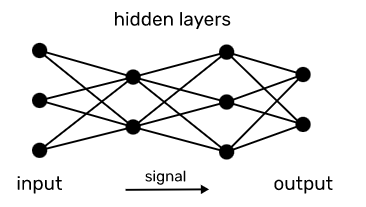

In [1]:
from IPython.display import Image
Image(filename='multilayer.png')

The goal of these hidden layers is to convert the input into a set of useful features which are then combined in the output layer to compute predictions. In other words, multilayer networks do not only learn to combine features but also learn these features by themselves. The idea is that each intermediate layer combines its inputs into a set of higher-level features that are then used in the next layer and so on. To achieve this, networks use activation functions which are simply functions that each neuron applies to its output.

#### Activation functions
We saw in the last subject that each neuron computes its output by multiplying the signal sent by its input neurons with its synaptic weights and by adding the neuron bias. In the multilayer neural network case, we can express the output 
x
(
l
)
j
 of the j-th neuron of layer 
l
 with the following expression.

x
(
l
)
j
=
∑
i
 
w
(
l
)
i
,
j
x
(
l
−
1
)
i
+
b
(
l
)
j
In this formula, we multiply the signal from each neuron from the previous layer 
x
(
l
−
1
)
i
 with the corresponding synaptic weight 
w
(
l
)
i
,
j
 and add the neuron bias 
b
(
l
)
j
. In multilayer networks, we apply an activation function 
ϕ
 to the output of each neuron.

x
(
l
)
j
=
ϕ
(
∑
i
 
w
(
l
)
i
,
j
x
(
l
−
1
)
i
+
b
(
l
)
j
)
Activation functions and hidden layers are really at the heart of neural networks. In fact, it’s possible to show that a network with a single hidden layer can approximate any continuous function. This is called the universal approximation theorem. If you want to learn more about it, we highly recommend reading chapter 4 of the Neural Networks and Deep Learning (NNDL) book which gives a visual explanation of the theorem.

#### Sigmoid and ReLU activation
There are many possible activation functions. For instance, we can use the sigmoid function that we saw in the unit about logistic regressions.

f
(
x
)
=
1
1
+
e
−
x
Here is a plot of the function for an input between -6 and +6.

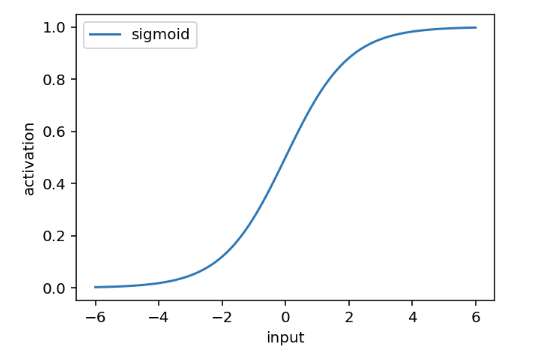

In [2]:
from IPython.display import Image
Image(filename='sigmoid.png')

One issue with the sigmoid function is that its derivative is close to zero (the curve is flat) when the input is very large or very small. Hence, the gradient update will be very small when updating the weights with gradient descent and the learning process becomes slow. This is called the vanishing gradient problem.

Another popular activation function is the Rectified Linear Unit (ReLU).

f
(
x
)
=
max
(
0
,
x
)
The function is zero when 
x
 is negative and equal to 
x
 when it’s positive.

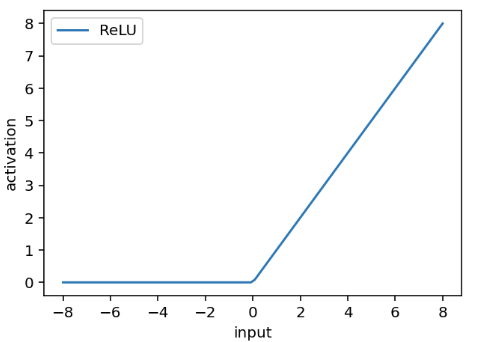

In [3]:
Image(filename='relu.png')

One of the advantages of the ReLU activation function is that it’s easy to implement and it seems to accelerate the learning process compared to the sigmoid one. You can take a look at this page if you want to learn more about activation functions.

#### Backpropagation
In the last course, we learned about the gradient descent method which updates the model parameters by computing the partial derivate of the loss function with respect to each parameter. In neural networks, we use the same idea to update the weights and biases of each neuron in our network. In practice, deep networks have a lot of parameters and it would be very inefficient to compute the partial derivative of each weight individually. However, there is a technique called backpropagation which can solve this issue. To avoid doing redundant computations, the backpropagation algorithm computes the error at the output neurons and propagates this information back through the network to compute the partial derivates layer after layer.

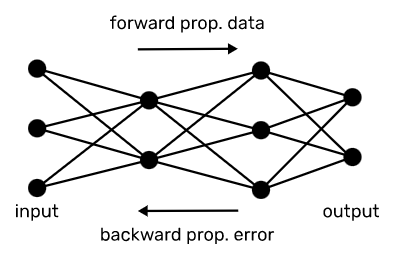

In [4]:
Image(filename='forward.png')

Backpropagation is usually performed internally by the deep learning framework. For instance, when using one of the optimizers in the tf.keras.optimizers module, TensorFlow will automatically compute the gradients in an efficient way using the backpropagation algorithm. If you want to learn more about the mathematics behind backpropagation, you can take a look at chapter 2 of the NNDL book.

#### Weights initialization
So far, we initialized the synaptic weights of each neuron to zero. This sounds reasonable if we standardized the data since we expect some weights to be positive, some to be negative, but in average, centered around zero. In multilayer networks, initializing the weights to a constant value (e.g., zero or one) is a bad idea because it makes all hidden units of a layer compute the exact same output. In that case, gradient descent will compute the same gradient updates and we will end up with copies of the hidden units with the same weight values.

One solution is to use a normal distribution to sample small random numbers. That way, each hidden neuron will start with different weights and will occupy a different role in our network. In practice, we often use the truncated normal distribution which drops values whose magnitude is more than 2 standard deviations away from the mean. For instance, here is the truncated normal distribution with a standard deviation of 0.01.

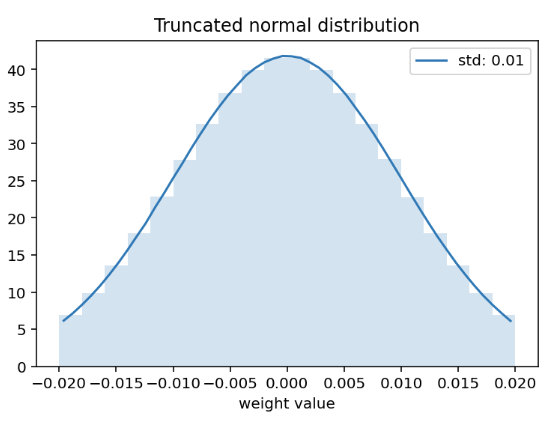

In [5]:
Image(filename='normal.png')

Ideally, we want to calibrate this standard deviation such that each neuron computes an output in a reasonable range for its activation function. When there are no activation function (e.g., in the output layer), it’s recommended to set the standard deviation to the inverse of the square root of the number of input neurons 
n

std =
1/
√
n
For layers with ReLU activations, the formula is a bit different.

std =
√
2/
n
We won’t go into the derivation of these two formulas, but you can take a look at this page if you want to learn more about it.

#### TensorFlow implementation
Now that we know the basic idea behind multilayer neural networks, let’s go through a concrete example. In this second part, we will implement a 2-layer neural network with 16 hidden units in the hidden layer to classify images from the MNIST data set.

##### Load the data
First, we will load the MNIST images, split them into train and validation sets and standardize the features using a StandardScaler transformer from Scikit-learn. The network is a bit larger this time. For this reason, we will train it using a slightly larger data set with 20 thousand images. You can download it from the resource section.



In [6]:
# Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf

# Load data
with np.load("c4_mnist-20k.npz", allow_pickle=False) as npz_file:
    # Load items into a dictionary
    mnist = dict(npz_file.items())

# Create train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    # Convert uint8 pixel values to float
    mnist["data"].astype(np.float32),
    mnist["labels"],
    test_size=500,
    random_state=0,
)

# Rescale train and validation data
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_valid_rescaled = scaler.transform(X_valid)

#### Create the network
Let’s now create our network.

Define network parameters and layers manually


In [7]:
# Define parameters

# Hidden layer with 16 units
W1 = tf.Variable(
    initial_value=tf.random.truncated_normal(
        shape=[784, 16],          # Shape
        stddev=(2 / 784) ** 0.5,  # Calibrating variance
        seed=0,
    )
)

b1 = tf.Variable(initial_value=tf.zeros(shape=[16]))

# Output layer
W2 = tf.Variable(
    initial_value=tf.random.truncated_normal(
        shape=[16, 10],               # Shape  
        stddev=1 / 16 ** 0.5, seed=0  # Calibrating variance
    )
)
b2 = tf.Variable(initial_value=tf.zeros(shape=[10]))


# Compute logits
hidden_output = tf.nn.relu(tf.add(tf.matmul(X_train_rescaled, W1), b1))  # ReLU
logits_output = tf.add(tf.matmul(hidden_output, W2), b2)

print(logits_output.shape)

(19500, 10)


In this code, we create a matrix of weights and vector of biases for each layer. The input layer has 784 input neurons which correspond to the pixels in the 28 by 28 grayscale images from the MNIST database. This input layer is connected to an intermediate hidden layer with 16 units. Hence, the shape of the weight matrix of the hidden layer is 
(
784
,
16
)
 and it bias vector has 16 elements. We create a second weight matrix to connect the hidden and output layers. Since there are ten output units, its shape is 
(
16
,
10
)
.

Finally, we compute the output of the hidden layer by multiplying the input and the weight matrices, add the bias and apply the ReLU activation function with the relu() function. Then, we compute the output of the network using this hidden tensor.

Note that we initialize the weights using the truncated_normal() function and calibrate the standard deviation using the formulas from above. For the output layer, we use the first formula since it has no activation function, but use the second one for the hidden layer since it uses the ReLU activation.

It’s not really convenient to work with the code from above because the number of hidden units is repeated at different places.

* The shape of W1
* The shape of b1
* The shape of W2
* The standard deviation of W2

To solve this issue, we can use the Dense() class from the keras.layers module with the appropriate initializers.

#### Define layers using built-in classes without explicitly defining the parameters


In [8]:
# Define hidden layer with 16 units
hidden_layer = tf.keras.layers.Dense(
    units=16,
    activation=tf.nn.relu,  # ReLU
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=2, distribution="truncated_normal", seed=0
    ),
    bias_initializer=tf.zeros_initializer(),
    name="hidden",
)

# Define output layer
logits_layer = tf.keras.layers.Dense(
    units=10,
    activation=None,  # No activation function
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1, distribution="truncated_normal", seed=0
    ),
    bias_initializer=tf.zeros_initializer(),
    name="output",
)

# Compute logits
hidden_output = hidden_layer(X_train_rescaled)
logits_output = logits_layer(hidden_output)

This time, we only have to write once the number of units in each layer which is more convenient if we want to experiment with it, e.g., try different sizes for the hidden layer. We define each fully-connected layer with the Dense() class which takes the input data, the number of output units, the activation function and the weights and bias initializers. We use the zeros_initializer() to initialize the biases to zero and the keras.initializers.VarianceScaling() to initialize the weights using the formulas from above. Note that we assign names to each layer. These names will make it easier to access the different layers and their elements.

The Dense() class creates the weights and biases variables with the appropriate shape and initialize them using the specified initializers.

Let’s now inspect the parameters of our networks.



In [9]:
# Extract the parameters of the hidden layer
W1 = hidden_layer.kernel  # or hidden_layer.trainable_variables[0]
b1 = hidden_layer.bias    # or hidden_layer.trainable_variables[1]

# Extract the parameters of the output layer
W2 = logits_layer.kernel
b2 = logits_layer.bias

In [10]:
print(W1.shape)  # W1
print(b1.shape)  # b1
print(W2.shape)  # W2
print(b2.shape)  # b2

(784, 16)
(16,)
(16, 10)
(10,)


Note, that these are “views” of the tf.Variables not “copies”.

#### Visualize weights before training
Before any training, let’s visualize the weights of the 16 hidden units using the code introduced in the previous subject of this course.



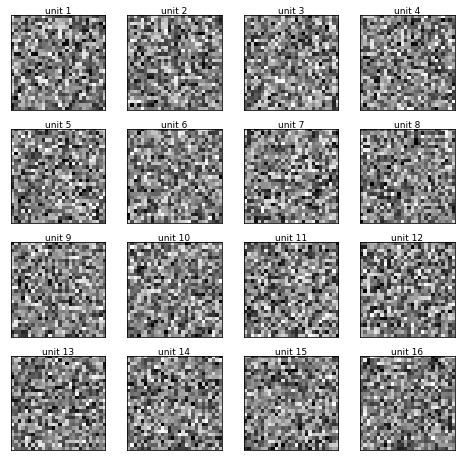

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create figure with 16 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the weights of the 16 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights = W1[:, i].numpy()

    # Reshape into 28 by 28 array
    weights = weights.reshape(28, 28)

    # Plot weights
    axis.set_title("unit {}".format(i + 1), size=9, pad=2)
    axis.imshow(weights, cmap=plt.cm.gray_r)  # Grayscale
    axis.get_xaxis().set_visible(False)  # Disable x-axis
    axis.get_yaxis().set_visible(False)  # Disable y-axis

plt.show()


As you can see, the weights of the hidden units are initialized according to a random noise distribution, namely the truncated normal distribution here.

#### Loss function and training operation
Now that the different layers of our neural network are specified, we can move on and define the loss function and training operations using the code from the previous units.

In [12]:
# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Define functions used to train the network (graph mode)

# Compute the logits
@tf.function
def compute_logits(x):
    hidden_output = hidden_layer(x)
    logits = logits_layer(hidden_output)
    return logits


# Compute the loss
@tf.function
def compute_loss(y, logits):
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    mean_ce = tf.reduce_mean(ce)
    return mean_ce


# Compute the accuracy
@tf.function
def compute_accuracy(y, logits):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    return acc


# Train the model (optimization procedure)
@tf.function
def train(x, y):
    with tf.GradientTape() as tape:
        logits = compute_logits(x)
        loss = compute_loss(y, logits)
    # Concatenate the trainable variables in one list using the '+' operation on lists
    variables = hidden_layer.trainable_variables + logits_layer.trainable_variables
    optimizer.minimize(loss=loss, var_list=variables, tape=tape)
    return logits, loss

The trainable_variables, or trainable_weights, attribute of a certain layer returns a list containing the kernel and the bias of that layer. For example, hidden_layer.trainable_variables[0] is nothing but hidden_layer.kernel (i.e. W1); while hidden_layer.trainable_variables[1] is nothing but hidden_layer.bias (i.e. b1).

#### Train network
Let’s train the network. This time, we will train the network using the entire data set several times. In the machine learning jargon, one pass of training through the entire training set is called an epoch. In practice, we usually shuffle the data before each epoch to get better results. Let’s modify our get_batches() function from the previous unit.



In [13]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y))  # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i : i + batch_size]
        yield X[batch_idx], y[batch_idx]

In this code, we create and shuffle a list of indexes and use it to iterate through our training data by small random batches.

Finally, let’s train our network during 50 epochs.



In [14]:
# Train and validation accuracy after each epoch
train_acc_values = []
valid_acc_values = []

# Set seed
np.random.seed(0)

# Train several epochs
for epoch in range(50):
    # Accuracy values (train) after each batch
    batch_acc = []

    # Get batches of data
    for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 64):
        # Run training
        batch_logits, _ = train(X_batch, y_batch)

        # Evaluate training accuracy (on current batch)
        acc = compute_accuracy(y_batch, batch_logits)
        batch_acc.append(acc)

    # Evaluate validation accuracy (on the whole data)
    valid_logits = compute_logits(X_valid_rescaled)
    valid_acc = compute_accuracy(y_valid, valid_logits)
    valid_acc_values.append(valid_acc)

    # Also save train accuracy on the whole data (we will use the mean batch score in each epoch)
    train_acc_values.append(np.mean(batch_acc))

    # Print progress
    print(
        "Epoch {} - valid: {:.3f} train: {:.3f} (mean)".format(
            epoch + 1, valid_acc, np.mean(batch_acc)
        )
    )

Epoch 1 - valid: 0.778 train: 0.609 (mean)
Epoch 2 - valid: 0.864 train: 0.832 (mean)
Epoch 3 - valid: 0.892 train: 0.872 (mean)
Epoch 4 - valid: 0.918 train: 0.890 (mean)
Epoch 5 - valid: 0.918 train: 0.903 (mean)
Epoch 6 - valid: 0.920 train: 0.910 (mean)
Epoch 7 - valid: 0.924 train: 0.917 (mean)
Epoch 8 - valid: 0.932 train: 0.921 (mean)
Epoch 9 - valid: 0.936 train: 0.925 (mean)
Epoch 10 - valid: 0.940 train: 0.928 (mean)
Epoch 11 - valid: 0.940 train: 0.932 (mean)
Epoch 12 - valid: 0.940 train: 0.934 (mean)
Epoch 13 - valid: 0.942 train: 0.935 (mean)
Epoch 14 - valid: 0.942 train: 0.938 (mean)
Epoch 15 - valid: 0.942 train: 0.940 (mean)
Epoch 16 - valid: 0.942 train: 0.941 (mean)
Epoch 17 - valid: 0.944 train: 0.943 (mean)
Epoch 18 - valid: 0.944 train: 0.945 (mean)
Epoch 19 - valid: 0.942 train: 0.946 (mean)
Epoch 20 - valid: 0.944 train: 0.946 (mean)
Epoch 21 - valid: 0.940 train: 0.948 (mean)
Epoch 22 - valid: 0.944 train: 0.949 (mean)
Epoch 23 - valid: 0.944 train: 0.950 (mea

In this code, we save the accuracy on each batch of training data and compare its mean to the accuracy on the validation set. This is a way to monitor overfitting and decide when to stop the network, i.e., the number of epochs to run.

You can try the implementation above with and without the tf.function (i.e. graph mode vs eager execution mode). You can then notice the difference in performance speed (~3 times faster with graph mode).

Let’s plot the validation accuracy after each epoch.

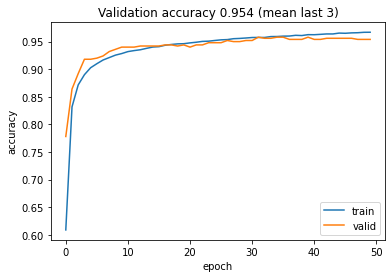

In [15]:
# Plot accuracy values
plt.plot(train_acc_values, label="train")
plt.plot(valid_acc_values, label="valid")
plt.title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(valid_acc_values[-3:])  # last three values
    )
)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

We can see that the training and validation scores are both improving during the first 20 epochs. The validation accuracy then reaches a plateau while the training score keeps increasing - this is a sign of overfitting. A common practice called early stopping is to stop the training process when the validation accuracy stops improving.

Note that, this time, we get an accuracy of 95% which is a lot better than our softmax network from the last subject with 85%.

#### Visualize weights after training
Finally, let’s visualize the weights of the 16 hidden units after training.

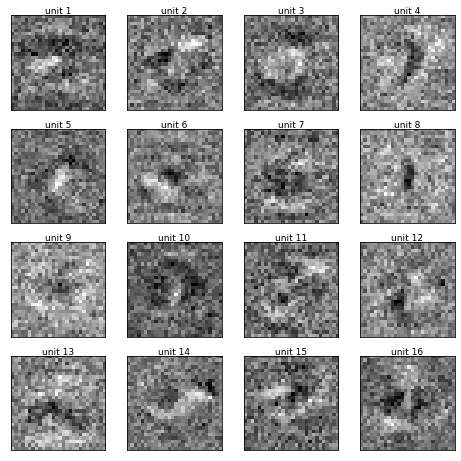

In [16]:
# Create figure with 16 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the weights of the 16 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights = W1[:, i].numpy()

    # Reshape into 28 by 28 array
    weights = weights.reshape(28, 28)

    # Plot weights
    axis.set_title("unit {}".format(i + 1), size=9, pad=2)
    axis.imshow(weights, cmap=plt.cm.gray_r)  # Grayscale
    axis.get_xaxis().set_visible(False)  # Disable x-axis
    axis.get_yaxis().set_visible(False)  # Disable y-axis

plt.show()


As we can see, the hidden units detect specific shapes that are then combined in the output layer.

Let’s see how by printing the weights matrix from the output layer.



In [17]:
import pandas as pd

# Output layer weights
df_weights = pd.DataFrame(
    W2.numpy(),
    index=["unit {}".format(i + 1) for i in range(16)],
    columns=["digit {}".format(i) for i in range(10)],
)
df_weights

,digit 0,digit 1,digit 2,digit 3,digit 4,digit 5,digit 6,digit 7,digit 8,digit 9
unit 1,-0.684115,-0.483690,0.175055,0.266550,-0.495632,0.028835,-0.584491,0.810601,0.478383,0.058303
unit 2,0.099149,0.179117,-0.510514,0.086059,-0.235637,0.159988,0.659742,0.229506,-0.289686,-0.745304
unit 3,0.554681,-0.339392,0.925679,0.562838,-0.519098,0.648453,-0.085011,0.048936,-0.385268,-0.011808
unit 4,-0.176113,0.436854,0.572851,-0.460283,-0.049449,-0.867059,-0.353053,0.347712,-0.306467,-0.019158
unit 5,0.966841,-0.070450,-0.064800,-0.096485,-0.853886,-0.196501,0.135636,0.523193,-0.163917,-0.256759
unit 6,-0.457847,-0.548064,-0.232903,0.563160,0.414557,0.298013,-0.547012,-0.569675,0.980053,0.215979
unit 7,-0.141247,-0.827904,0.482365,-0.309635,0.282399,0.218790,0.479303,-0.606647,-0.296922,0.675316
unit 8,-0.221665,0.686463,-0.635472,-0.432301,0.090983,-0.122593,0.093031,-0.114357,0.202911,-0.425738
unit 9,0.130258,0.219185,-0.487689,0.266575,0.054558,0.086692,0.147322,-0.211909,-0.228958,0.791649
unit 10,0.310643,-0.033871,-0.134482,-0.706207,0.259524,-0.106563,-0.600248,0.018762,-0.072950,0.733168


In this code, we load the weights into a DataFrame and label each row and columns. And now that we have the information in this nice format, we can also use seaborn’s heatmap to visualize it with colors.



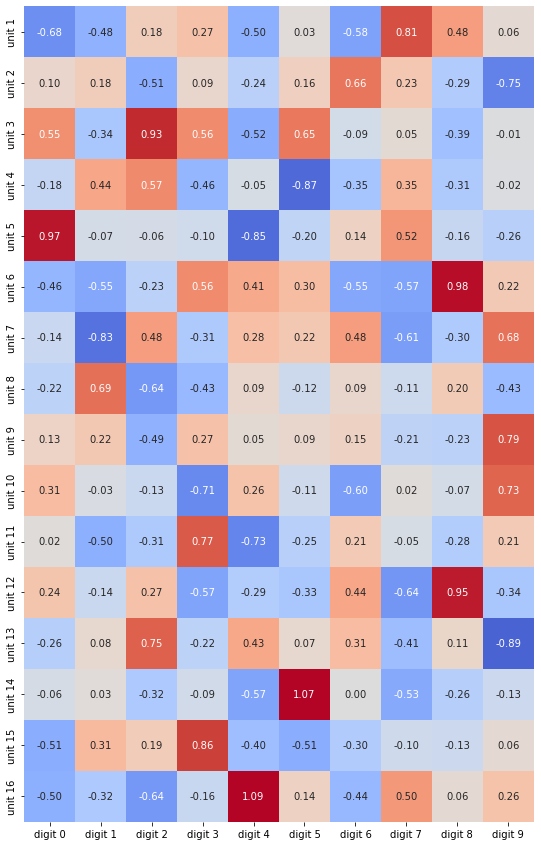

In [18]:
import seaborn as sns

plt.figure(figsize=(10, 15))
sns.heatmap(df_weights, square=True, annot=True, fmt=".2f",
            cbar=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


This weights matrix tells us how each output neuron computes its activation. You can see the contribution of each of the 16 hidden units to the 10 different outputs (digits). For instance, we can see that the hidden units that learned a rounded curve contribute more to the digits having such shape.

#### Summary
In this unit, we saw the idea behind multilayer networks such as hidden layers and activation functions, and saw how to implement one using TensorFlow. In practice, it’s common to build 2- or 3-layer networks with this architecture of dense or fully-connected layers neurons. These networks are very powerful but can easily overfit the training data. In the next unit, we will learn about dropout which is a very efficient way to reduce overfitting in neural networks.